In [1]:
import pandas
import bt

In [6]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [7]:
# first let's create a helper function to create a ma cross backtest
def ma_cross(ticker, start='2010-01-01',
             short_ma=50, long_ma=200, name='ma_cross'):
    # these are all the same steps as above
    data = bt.get(ticker, start=start)
    short_sma = data.rolling(short_ma).mean()
    long_sma  = data.rolling(long_ma).mean()

    # target weights
    tw = long_sma.copy()
    tw[short_sma > long_sma] = 1.0
    tw[short_sma <= long_sma] = -1.0
    tw[long_sma.isnull()] = 0.0

    # here we specify the children (3rd) arguemnt to make sure the strategy
    # has the proper universe. This is necessary in strategies of strategies
    s = bt.Strategy(name, [WeighTarget(tw), bt.algos.Rebalance()], [ticker])

    return bt.Backtest(s, data)

# ok now let's create a few backtests and gather the results.
# these will later become our "synthetic securities"
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's run these strategies now
res = bt.run(t1, t2)

<Axes: title={'center': 'Equity Progression'}>

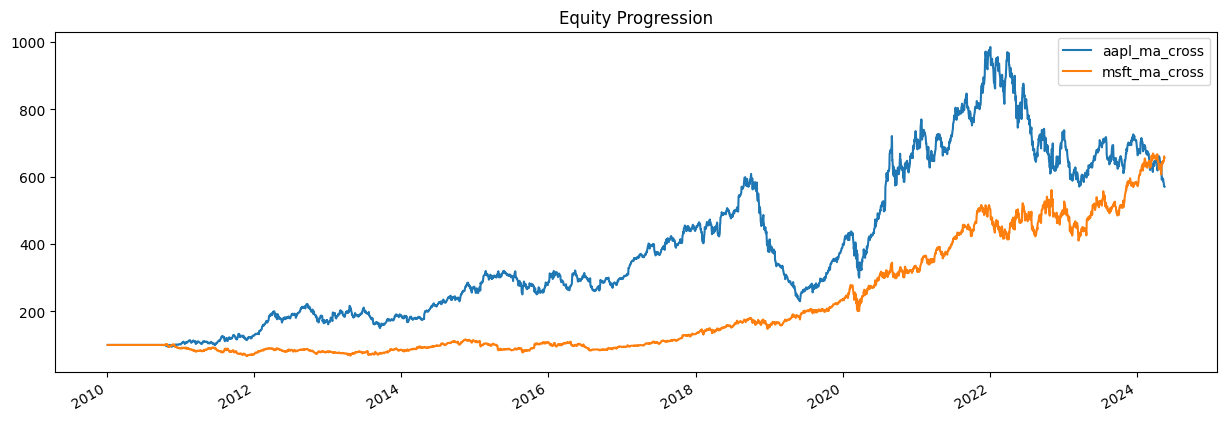

In [9]:
res.plot()

In [10]:
res['aapl_ma_cross'].prices

2010-01-03    100.000000
2010-01-04    100.000000
2010-01-05    100.000000
2010-01-06    100.000000
2010-01-07    100.000000
                 ...    
2024-05-13    581.301126
2024-05-14    577.712455
2024-05-15    570.653962
2024-05-16    570.293028
2024-05-17    570.202909
Name: aapl_ma_cross, Length: 3619, dtype: float64

In [11]:
res['msft_ma_cross'].prices

2010-01-03    100.000000
2010-01-04    100.000000
2010-01-05    100.000000
2010-01-06    100.000000
2010-01-07    100.000000
                 ...    
2024-05-13    644.613452
2024-05-14    649.038447
2024-05-15    660.386173
2024-05-16    657.123898
2024-05-17    655.906397
Name: msft_ma_cross, Length: 3619, dtype: float64

In [12]:
# now that we have run the strategies, let's extract
# the data to create "synthetic securities"
data = bt.merge(res['aapl_ma_cross'].prices, res['msft_ma_cross'].prices)

In [13]:
data

,aapl_ma_cross,msft_ma_cross
2010-01-03,100.000000,100.000000
2010-01-04,100.000000,100.000000
2010-01-05,100.000000,100.000000
2010-01-06,100.000000,100.000000
2010-01-07,100.000000,100.000000
...,...,...
2024-05-13,581.301126,644.613452
2024-05-14,577.712455,649.038447
2024-05-15,570.653962,660.386173
2024-05-16,570.293028,657.123898


In [14]:
# now we have our new data. This data is basically the equity
# curves of both backtested strategies. Now we can just use this
# to test any old strategy, just like before.
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

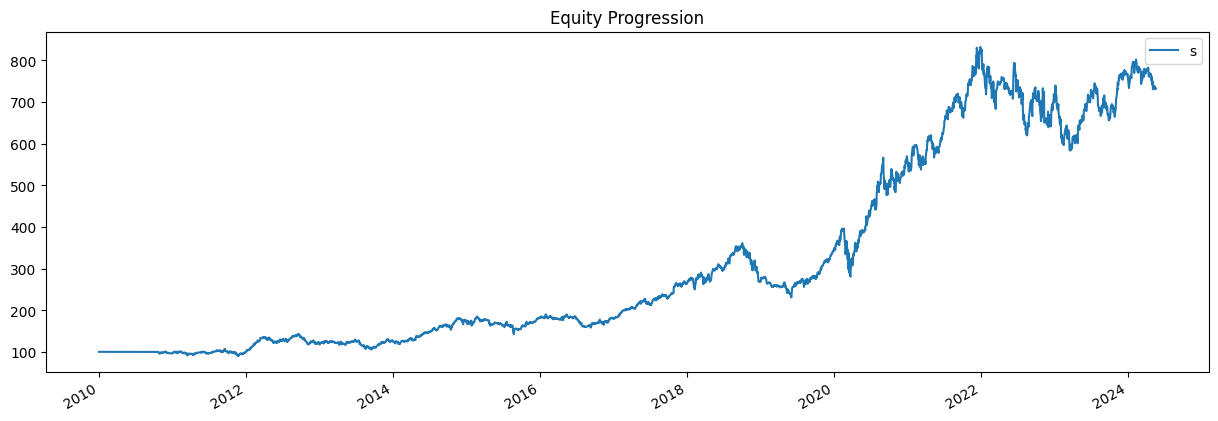

In [15]:
res.plot();

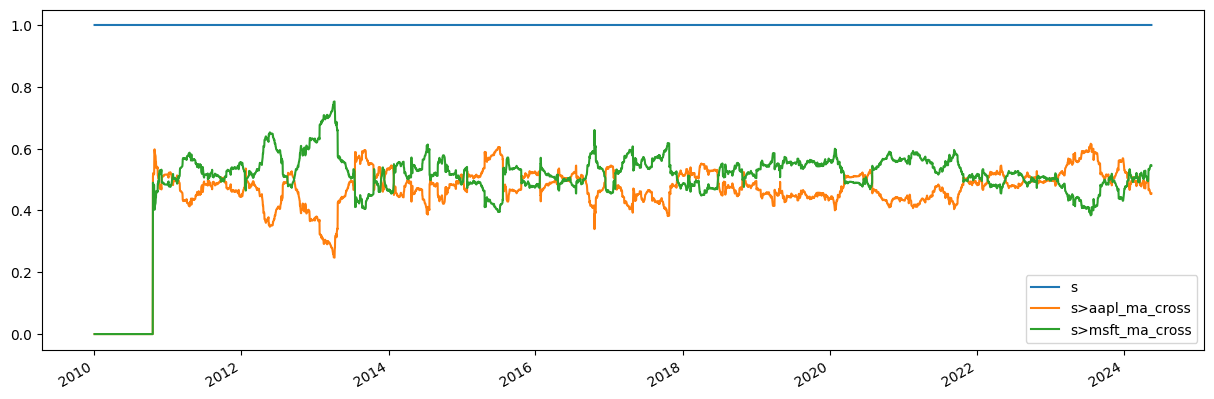

In [16]:
res.plot_weights();

In [17]:
# once again, we will create a few backtests
# these will be the child strategies
t1 = ma_cross('aapl', name='aapl_ma_cross')
t2 = ma_cross('msft', name='msft_ma_cross')

# let's extract the data object
data = bt.merge(t1.data, t2.data)

# now we create the parent strategy
# we specify the children to be the two
# strategies created above
s = bt.Strategy('s', [bt.algos.SelectAll(),
                      bt.algos.WeighInvVol(),
                      bt.algos.Rebalance()],
                [t1.strategy, t2.strategy])

# create and run
t = bt.Backtest(s, data)
res = bt.run(t)

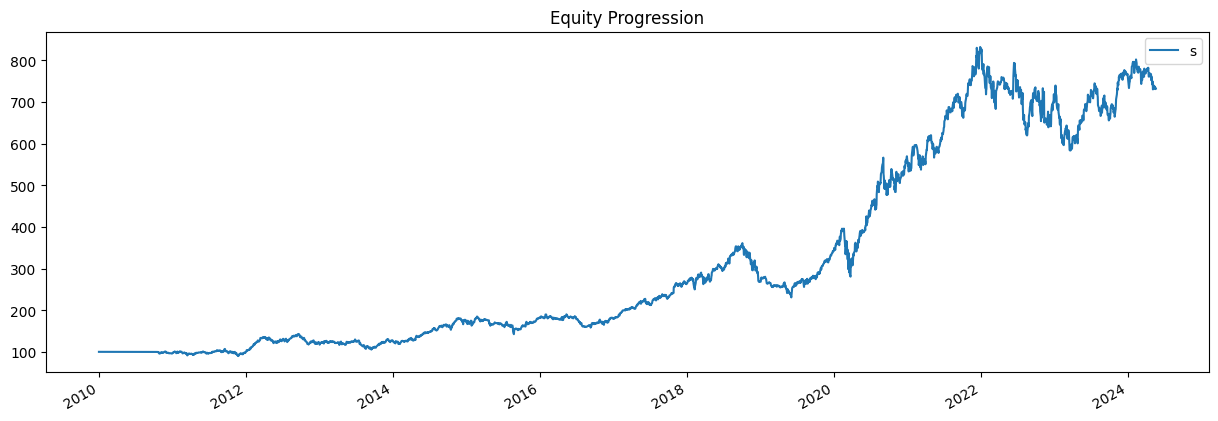

In [18]:
res.plot();

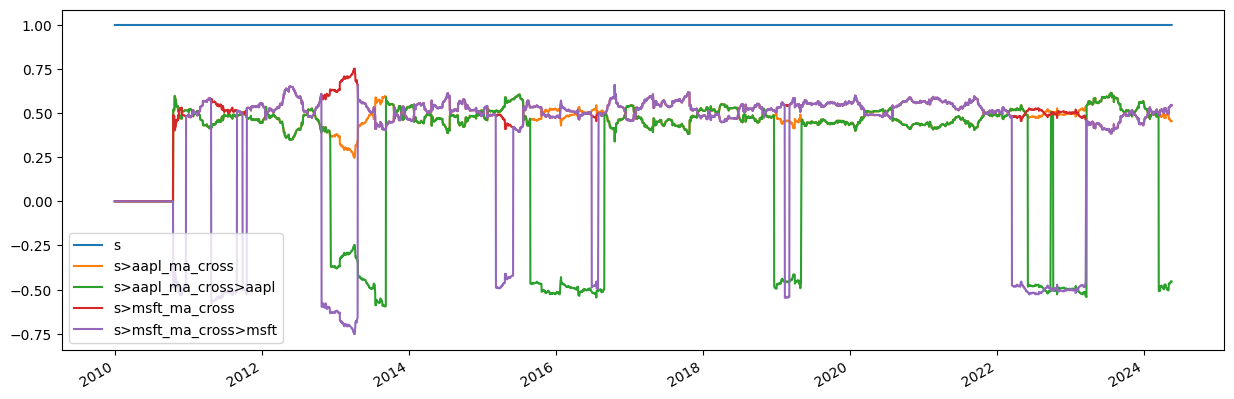

In [19]:
res.plot_weights();